In [1]:
import gzip
from collections import defaultdict
import math
import random
import numpy as np
import scipy.optimize

def readGz(f):
  for l in gzip.open(f):
    yield eval(l)

#reading data
rawdata=list(readGz("reviews_Electronics_5.json.gz"))

In [2]:
import string
import pandas as pd
def pad(c): return ' '+c
remove_table = str.maketrans({}.fromkeys(string.punctuation))
keep_table = str.maketrans({pun:pad(pun) for pun in string.punctuation})
table={True: remove_table, False:keep_table}

#clean the data before fitting
def clean(text,table,remove):
    return text.lower().translate(table[remove])

data=rawdata
for d in data:
    d['reviewText']=clean(d['reviewText'],table,True)
data=data[:50000]
df=pd.DataFrame.from_dict(data)
df.drop(columns=['helpful','reviewTime','reviewerID','reviewerName',
                 'summary','unixReviewTime'],inplace=True)

In [3]:
from sklearn.pipeline import Pipeline
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

pipeline=Pipeline([
    ('vect', CountVectorizer()),
    ('clf', linear_model.Ridge()),
])

params={'clf__alpha':[0.1,1,10,100,1000],
       'clf__fit_intercept':[True],
       'vect__max_features': [1000,2000,3000],
       'vect__stop_words':['english',None],
       'vect__ngram_range':[(1,1),(1,2),(1,3)]
       }
grid_search=GridSearchCV(pipeline, params,cv=3,verbose=1,
                         scoring='neg_mean_squared_error')
grid_search.fit(df.reviewText,df.overall)

Fitting 3 folds for each of 90 candidates, totalling 270 fits


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed: 129.6min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...it_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'clf__alpha': [0.1, 1, 10, 100, 1000], 'clf__fit_intercept': [True], 'vect__max_features': [1000, 2000, 3000], 'vect__stop_words': ['english', None], 'vect__ngram_range': [(1, 1), (1, 2), (1, 3)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=1)

In [4]:
grid_search.best_score_

-0.9219689673856968

In [5]:
grid_search.best_params_

{'clf__alpha': 100,
 'clf__fit_intercept': True,
 'vect__max_features': 3000,
 'vect__ngram_range': (1, 2),
 'vect__stop_words': None}

In [6]:
res=pd.DataFrame(grid_search.cv_results_)

/Users/keithzeng/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/keithzeng/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/keithzeng/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/keithzeng/an

In [7]:
res_n=res.fillna('None')
res_n.mean_train_score=-res_n.mean_train_score
res_n.mean_test_score=-res_n.mean_test_score

param_vect__stop_words  param_vect__max_features
None                    1000                        1.000009
                        2000                        0.958606
                        3000                        0.940222
english                 1000                        1.009369
                        2000                        0.983847
                        3000                        0.982212
Name: mean_test_score, dtype: float64

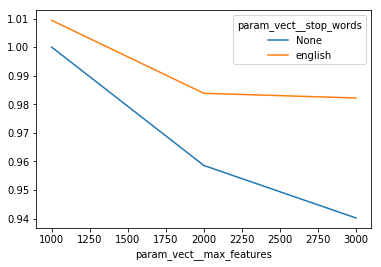

In [14]:
grouped=res_n.groupby(['param_vect__stop_words','param_vect__max_features']).mean()
grouped.unstack('param_vect__stop_words').plot(y='mean_test_score')
grouped['mean_test_score']

param_vect__stop_words  param_clf__alpha
None                    0.1                 0.968685
                        1.0                 0.968531
                        10.0                0.967044
                        100.0               0.958231
                        1000.0              0.968905
english                 0.1                 0.999527
                        1.0                 0.998814
                        10.0                0.992698
                        100.0               0.969771
                        1000.0              0.998237
Name: mean_test_score, dtype: float64

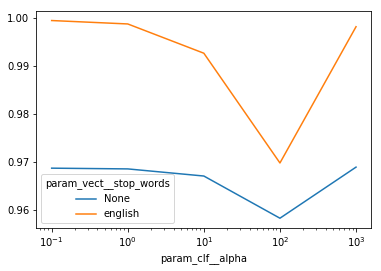

In [9]:
grouped=res_n.groupby(['param_vect__stop_words','param_clf__alpha']).mean()
grouped.unstack('param_vect__stop_words').plot(y='mean_test_score',logx=True)
grouped['mean_test_score']

param_vect__ngram_range  param_vect__max_features
(1, 1)                   1000                        1.000338
                         2000                        0.973197
                         3000                        0.967842
(1, 2)                   1000                        1.006641
                         2000                        0.969214
                         3000                        0.956352
(1, 3)                   1000                        1.007088
                         2000                        0.971268
                         3000                        0.959457
Name: mean_test_score, dtype: float64

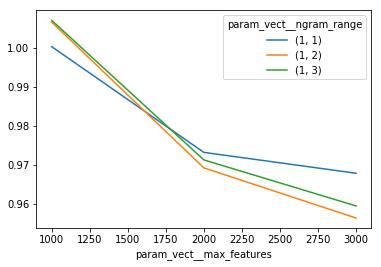

In [10]:
grouped=res_n.groupby(['param_vect__ngram_range','param_vect__max_features']).mean()
grouped.unstack('param_vect__ngram_range').plot(y='mean_test_score')
grouped['mean_test_score']

param_vect__ngram_range  param_clf__alpha
(1, 1)                   0.1                 0.985286
                         1.0                 0.984815
                         10.0                0.980849
                         100.0               0.964835
                         1000.0              0.986512
(1, 2)                   0.1                 0.982532
                         1.0                 0.982108
                         10.0                0.978364
                         100.0               0.962500
                         1000.0              0.981507
(1, 3)                   0.1                 0.984500
                         1.0                 0.984095
                         10.0                0.980400
                         100.0               0.964667
                         1000.0              0.982693
Name: mean_test_score, dtype: float64

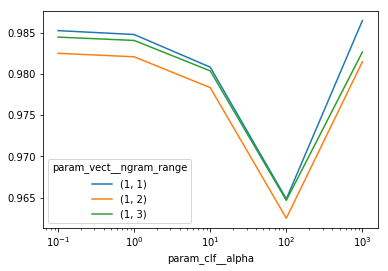

In [11]:
grouped=res_n.groupby(['param_vect__ngram_range','param_clf__alpha']).mean()
grouped.unstack('param_vect__ngram_range').plot(y='mean_test_score',logx=True)
grouped['mean_test_score']

param_vect__stop_words  param_vect__ngram_range  param_clf__alpha  param_vect__max_features
None                    (1, 1)                   0.1               1000                        0.993847
                                                                   2000                        0.959229
                                                                   3000                        0.946960
                                                 1.0               1000                        0.993800
                                                                   2000                        0.959033
                                                                   3000                        0.946737
                                                 10.0              1000                        0.993092
                                                                   2000                        0.957197
                                                                   3000     

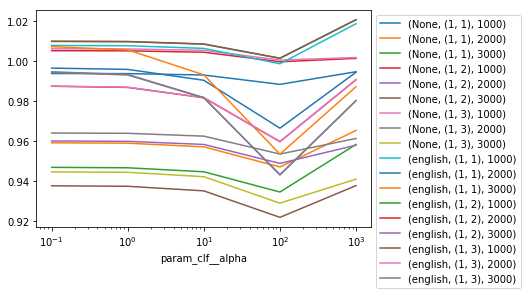

In [15]:
grouped=res_n.groupby(['param_vect__stop_words','param_vect__ngram_range','param_clf__alpha','param_vect__max_features']).mean()
ax=grouped.unstack('param_vect__stop_words').unstack('param_vect__ngram_range').unstack('param_vect__max_features').plot(y='mean_test_score',logx=True)
ax.legend(loc="upper left", bbox_to_anchor=(1,1))
grouped['mean_test_score']

In [16]:
grouped['mean_test_score'].to_csv("count.txt", sep='\t')